# Import e funzioni 

In [2]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import os

# Convertire miglia nautiche in gradi (approssimazione)
def miles_to_degrees(miles):
    return miles / 60.0

radius_degrees = miles_to_degrees(10)  # raggio di 10 miglia nautiche

# Funzione per creare un cerchio attorno a un punto
def create_circle_around_point(point, radius):
    return point.buffer(radius)

# read dati

In [3]:
ais=pd.read_csv('/kaggle/input/ais-sample/2022_8100595_emissions_hourly.csv',low_memory=False).reset_index(drop=False) 
ports=pd.read_csv('/kaggle/input/best-centroids-1/best_centroids (1).csv')
ports.columns=['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE']

# Accorpamento dei centroidi vicini

In [4]:
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN
from shapely.geometry import Point

# Supponiamo che df sia il tuo GeoDataFrame con punti dei porti
df = ports

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Supponiamo che 'df' sia il tuo DataFrame
# Seleziona le colonne delle coordinate
coordinates = df[['LONGITUDE', 'LATITUDE']]

# Standardizza i dati
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

# Crea e applica l'algoritmo DBSCAN
db = DBSCAN(eps=0.1, min_samples=1).fit(scaled_coordinates)

# Aggiungi i cluster al DataFrame
df['cluster'] = db.labels_

# Trova i cluster unici
clusters = df['cluster'].unique()

# Campiona un punto per ogni cluster
ports = df.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)



/tmp/ipykernel_36/96664247.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ports = df.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)


# Trasformiamo i dataset in geopandas

In [24]:
# Leggi il dataframe dei porti e trasformalo in geopandas e crea cerchio
ports=ports[['PORT_CODE','LONGITUDE','LATITUDE']].copy()
ports['geometry'] = ports.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ports_gdf = gpd.GeoDataFrame(ports, geometry='geometry')
ports_gdf['geometry'] = ports_gdf['geometry'].apply(lambda point: create_circle_around_point(point, radius_degrees))
ports_gdf.crs = "EPSG:4326"
ports_gdf['PORT_CODE'] = ports_gdf['PORT_CODE'].astype(str)



# Leggi il dataframe dei AIS e trasformalo in geopandas, fai il join con i porti e ritorna una lista dei viaggi 
ais=pd.read_csv('/kaggle/input/ais-sample/2022_9113745_emissions_hourly.csv',low_memory=False).reset_index(drop=False)
imo=ais['IMO']
ais=ais[['index', 'LONGITUDE','LATITUDE','SOG']].copy()
ais['geometry'] = ais.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ais_gdf = gpd.GeoDataFrame(ais, geometry='geometry')
ais_gdf.crs = "EPSG:4326"  

# Ora che sono tutti geopandas possiamo fare il join per vedere ogni segnale rispetto a ogni porto
intersections = gpd.sjoin(ais_gdf, ports_gdf, how='left', predicate='intersects')
intersections_cleaned = intersections.drop_duplicates(subset=['index'])
intersections_cleaned.loc[intersections_cleaned['SOG'] > 3, 'PORT_CODE'] = 'move'
intersections_cleaned['PORT_CODE'] = intersections_cleaned['PORT_CODE'].fillna('unknown')

 

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [34]:

result = []
for code in intersections_cleaned['PORT_CODE']:
    if code != 'move':
        # Aggiungi il codice se non è già l'ultimo aggiunto
        if not result or result[-1] != code:
            result.append(code)
arcs = [(result[i], result[i + 1]) for i in range(len(result) - 1)]
filtered_arcs = [(source, destination) for source, destination in arcs if source != 'unknown' and destination != 'unknown']
filtered_arcs

[('194', '113'), ('194', '113')]

In [28]:
intersections_cleaned.to_csv('/kaggle/working/intersections_cleaned.csv')

# da ogni ais accoppia porti, e definisce i viaggi


In [ ]:
# Leggi il dataframe dei porti e trasformalo in geopandas e crea cerchio
ports=ports[['PORT_CODE','LONGITUDE','LATITUDE']].copy()
ports['geometry'] = ports.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ports_gdf = gpd.GeoDataFrame(ports, geometry='geometry')
ports_gdf['geometry'] = ports_gdf['geometry'].apply(lambda point: create_circle_around_point(point, radius_degrees))
ports_gdf.crs = "EPSG:4326"
ports_gdf['PORT_CODE'] = ports_gdf['PORT_CODE'].astype(str)


directory = '/kaggle/input/ais-sample/'
data = []

for file_name in tqdm(os.listdir(directory)):
    if file_name.endswith('.csv'):
        # Leggi il dataframe dei AIS e trasformalo in geopandas,
        file_path = os.path.join(directory, file_name)
        ais = pd.read_csv(file_path, low_memory=False).reset_index(drop=False)
        imo = file_name.split('_')[1]
        ais=ais[['index', 'LONGITUDE','LATITUDE','SOG']].copy()
        ais['geometry'] = ais.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
        ais_gdf = gpd.GeoDataFrame(ais, geometry='geometry')
        ais_gdf.crs = "EPSG:4326" 
        # Ora che sono tutti geopandas possiamo fare il join per vedere ogni segnale rispetto a ogni porto
        intersections = gpd.sjoin(ais_gdf, ports_gdf, how='left', predicate='intersects')
        intersections_cleaned = intersections.drop_duplicates(subset=['index'])
        intersections_cleaned.loc[intersections_cleaned['SOG'] > 3, 'PORT_CODE'] = 'move'
        intersections_cleaned['PORT_CODE'] = intersections_cleaned['PORT_CODE'].fillna('unknown')
        result = []
        for code in intersections_cleaned['PORT_CODE']:
            if code != 'move':
                # Aggiungi il codice se non è già l'ultimo aggiunto
                if not result or result[-1] != code:
                    result.append(code)
        arcs = [(result[i], result[i + 1]) for i in range(len(result) - 1)]
        filtered_arcs = [(source, destination) for source, destination in arcs if source != 'unknown' and destination != 'unknown']
        for source, destination in filtered_arcs:
            data.append({'IMO': imo, 'Source': source, 'Destination': destination})
archi = pd.DataFrame(data)
archi.to_csv('archi.csv', index=False)

In [37]:
archi

,IMO,Source,Destination
0,9820427,192,190
1,9580091,192,199
2,8913485,81,44
3,8913485,166,72
4,8913485,194,113
...,...,...,...
524,9488322,194,113
525,9488322,166,194
526,9488322,113,194
527,9113745,194,113


# plot del grafo

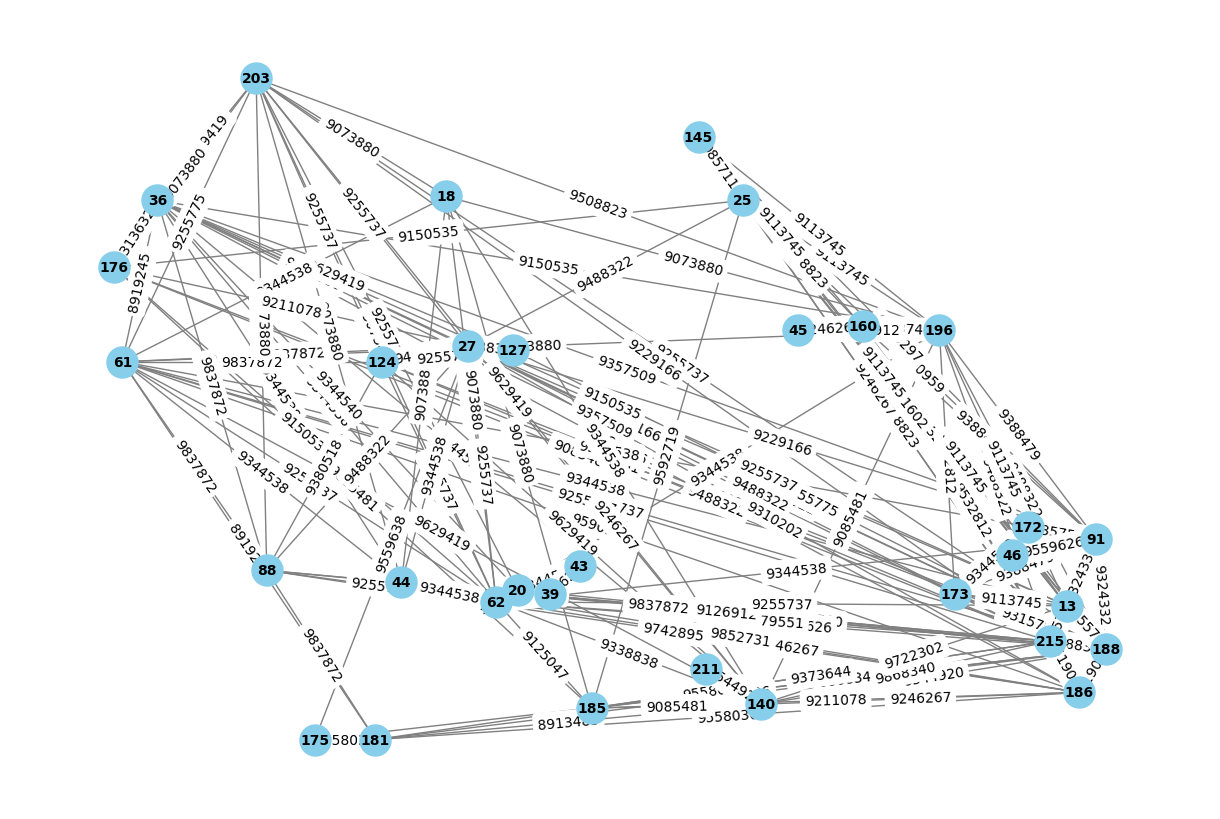

In [188]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Supponiamo che 'ports' e 'df_viaggi' siano già definiti

# Carica il DataFrame dei porti (se non è già caricato)
# ports = pd.read_csv('path_to_ports.csv')

# Crea un dizionario di posizioni per i nodi utilizzando le coordinate dei porti
pos = ports.set_index('PORT_CODE')[['LONGITUDE', 'LATITUDE']].to_dict(orient='index')
pos = {k: (v['LONGITUDE'], v['LATITUDE']) for k, v in pos.items()}

# Rimuovi duplicati e converti i codici portuali in interi
df_viaggi = df_viaggi.drop_duplicates()
df_viaggi['Source'] = df_viaggi['Source'].astype(int)
df_viaggi['Destination'] = df_viaggi['Destination'].astype(int)

# Crea il grafo
G = nx.from_pandas_edgelist(df_viaggi, 'Source', 'Destination', ['IMO'])

# Disegna il grafo con le posizioni basate sulle coordinate
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'IMO')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Mostra il grafico
plt.show()


# top 10 nodi 

In [197]:
import pandas as pd
import networkx as nx

# Supponiamo che 'df_viaggi' e 'G' siano già definiti

# Calcola il grado di ogni nodo
degree_sequence = G.degree()  # Restituisce una lista di tuple (nodo, grado)

# Ordina i nodi in base al grado in modo decrescente
sorted_nodes = sorted(degree_sequence, key=lambda x: x[1], reverse=True)

# Se vuoi i primi N nodi con grado maggiore (per esempio, i primi 10)
N = 10
top_nodes = sorted_nodes[:N]

# Crea un DataFrame per visualizzare i nodi e i loro gradi
top_nodes_df = pd.DataFrame(top_nodes, columns=['Nodo', 'Grado'])

print(top_nodes_df)

ports[ports['PORT_CODE']==27]

   Nodo  Grado
0   188     24
1   215     20
2    62     20
3    27     17
4    36     16
5    61     16
6   140     15
7   196     15
8    91     14
9   203     14


,PORT_CODE,LONGITUDE,LATITUDE,geometry
14,27,-3.390625,53.46875,POINT (-3.390625 53.46875)


# distribuzione del grado dei nodi

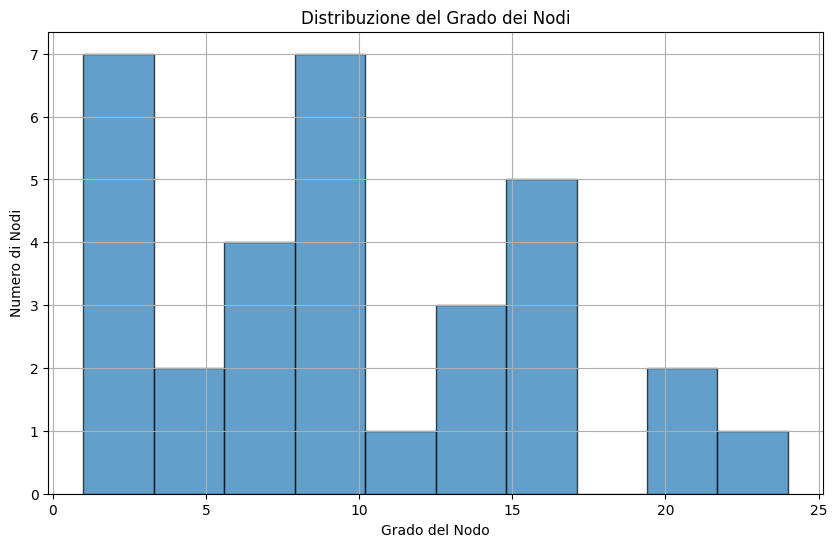

In [191]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Supponiamo che 'df_viaggi' e 'G' siano già definiti

# Calcola il grado dei nodi
degree_sequence = [G.degree(n) for n in G.nodes()]
degrees = degree_sequence  # Gradi dei nodi

# Crea un istogramma della distribuzione dei gradi
plt.figure(figsize=(10, 6))
plt.hist(degrees, edgecolor='black', alpha=0.7)
plt.title('Distribuzione del Grado dei Nodi')
plt.xlabel('Grado del Nodo')
plt.ylabel('Numero di Nodi')
plt.grid(True)
plt.show()


In [167]:
ports[ports['PORT_CODE']==196]

,PORT_CODE,LONGITUDE,LATITUDE,geometry
1,196,0.435791,53.59375,POINT (0.435791015625 53.59375)


# Esporto in formato SHAPE

In [164]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

ais
# Convertire il DataFrame in geometrie di punti
geometry = [Point(xy) for xy in zip(ais['LONGITUDE'], ais['LATITUDE'])]

# Creare un GeoDataFrame
gdf = gpd.GeoDataFrame(ais, geometry=geometry)

# Impostare un sistema di riferimento spaziale (SRID), ad esempio WGS84
gdf.crs = "EPSG:4326"

# Esportare come shapefile
gdf.to_file('output_shapefile.shp')
